In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import pandas as pd
import plotly.express as px
import random
from sklearn.preprocessing import MinMaxScaler

sys.path.append(os.path.abspath('../src/'))
from ActivationFunctions import *
from NeuralNetwork import *
from MyUtils import *

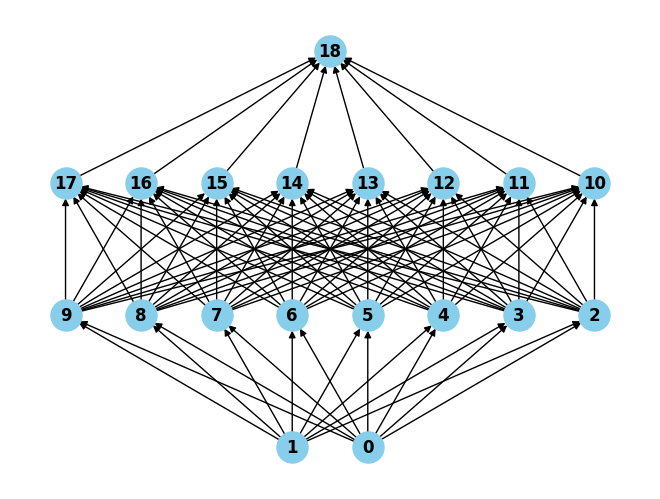

In [2]:
TR_INPUT = 2
TR_OUTPUT = 1
topology = create_stratified_topology([TR_INPUT,8, 8,TR_OUTPUT],
                                      [[None, []], [None, []]] + [['sigmoid', [1]]]*4 + [['softplus', []]]*4 + [['sigmoid', [1]]]*4 + [['softplus', []]]*4 + [['identity', []]])
NeuralNetwork.display_topology(topology)

In [3]:
topology

{0: ['input_0', None, [], [2, 3, 4, 5, 6, 7, 8, 9]],
 1: ['input_0', None, [], [2, 3, 4, 5, 6, 7, 8, 9]],
 2: ['hidden_1', 'sigmoid', [1], [10, 11, 12, 13, 14, 15, 16, 17]],
 3: ['hidden_1', 'sigmoid', [1], [10, 11, 12, 13, 14, 15, 16, 17]],
 4: ['hidden_1', 'sigmoid', [1], [10, 11, 12, 13, 14, 15, 16, 17]],
 5: ['hidden_1', 'sigmoid', [1], [10, 11, 12, 13, 14, 15, 16, 17]],
 6: ['hidden_1', 'softplus', [], [10, 11, 12, 13, 14, 15, 16, 17]],
 7: ['hidden_1', 'softplus', [], [10, 11, 12, 13, 14, 15, 16, 17]],
 8: ['hidden_1', 'softplus', [], [10, 11, 12, 13, 14, 15, 16, 17]],
 9: ['hidden_1', 'softplus', [], [10, 11, 12, 13, 14, 15, 16, 17]],
 10: ['hidden_2', 'sigmoid', [1], [18]],
 11: ['hidden_2', 'sigmoid', [1], [18]],
 12: ['hidden_2', 'sigmoid', [1], [18]],
 13: ['hidden_2', 'sigmoid', [1], [18]],
 14: ['hidden_2', 'softplus', [], [18]],
 15: ['hidden_2', 'softplus', [], [18]],
 16: ['hidden_2', 'softplus', [], [18]],
 17: ['hidden_2', 'softplus', [], [18]],
 18: ['output_3', 'ide

In [4]:
NN = NeuralNetwork(topology, -0.75, 0.75, True, RANDOM_STATE)

In [5]:
len_dataset = 1010
len_training = 1000
len_validation = 10

f1 = lambda x : x[1]**2 + x[1]*5 + x[0]**2 + x[0]*5 if (x[0] > 0 and x[1] > 0) or (x[0] < 0 and x[1] < 0) else -x[1]**2 -x[1]*5 - x[0]**2 -x[0]*5
#f2 = lambda x : 3*x[0]**3 - 20*x[1]**2 + 2 
#f3 = lambda x : 2*math.log(abs(x[0]*5)) - 2*math.log(abs(x[1]*5)) + 1

dummy = create_dataset(len_dataset, TR_INPUT, [-10, 10], 
                      [f1],
                       #f2,
                       #f3],
                      RANDOM_STATE)

tr_df = dummy[:len_training]
val_df = dummy[-len_validation:]
tr_df.sample(10, random_state=RANDOM_STATE)

,input_1,input_2,output_1
144,5.877283,-4.974568,-63.802353
833,-6.495916,-0.695425,6.723835
270,-1.949781,-3.531345,-11.133587
468,8.711151,-8.512243,-149.336973
962,3.806838,-9.197647,-72.134686
186,5.617542,-7.496826,-78.362747
942,-6.662165,0.761217,-15.459157
516,-4.938241,-4.777771,-1.366743
286,-7.370881,-9.162829,55.618770
458,-1.138026,2.691393,-16.305532


In [6]:
scaler_out = MinMaxScaler()
scaler_in = MinMaxScaler()
scaler_in.fit(tr_df.values[:,:TR_INPUT])
scaler_out.fit(tr_df.values[:,TR_INPUT:])

tr_normalized = np.empty((len_training, TR_OUTPUT+TR_INPUT))
tr_normalized[:,:TR_INPUT] = scaler_in.transform(tr_df.values[:,:TR_INPUT])
tr_normalized[:,TR_INPUT:] = scaler_out.transform(tr_df.values[:,TR_INPUT:])

val_normalized = np.empty((len_validation, TR_OUTPUT+TR_INPUT))
val_normalized[:,:TR_INPUT] = scaler_in.transform(val_df.values[:,:TR_INPUT])
val_normalized[:,TR_INPUT:] = scaler_out.transform(val_df.values[:,TR_INPUT:])

In [7]:
tr_df_normalized = pd.DataFrame(data = tr_normalized, columns=tr_df.columns)
val_df_normalized = pd.DataFrame(data = val_normalized, columns=tr_df.columns)

In [8]:
training_set = tr_df.values
validation_set = val_df.values
metrics = [ErrorFunctions.mean_squared_error, ] #ErrorFunctions.mean_euclidean_error, 

batch_size = 25
max_epochs = 5000
error_decrease_tolerance = 0.000001
patience = 10

lambda_tikhonov = 0.00001
alpha_momentum = 0.25
learning_rate = 0.01/batch_size
# beacause of the momentum is used the learning rate needs to be a little less?!?!?

collect_datas = True
collect_datas_batch = False # per il momento. molto costoso!!!! False di default

stats = NN.train(tr_normalized, val_normalized, batch_size, max_epochs, error_decrease_tolerance, patience, 
                   learning_rate, lambda_tikhonov, alpha_momentum, metrics, collect_datas, collect_datas_batch)

In [9]:
tr_predictions_normalized = NN.predict_array(tr_normalized[:,:TR_INPUT])
tr_predictions = scaler_out.inverse_transform(tr_predictions_normalized)

In [10]:
pd.options.mode.chained_assignment = None
prediction_col = ['prediction_1']#, 'prediction_2', 'prediction_3']
tr_df[prediction_col] = tr_predictions
for col in prediction_col:
    tr_df[col + '_err'] = (tr_df[col] - tr_df['output_' + col[-1]])**2
    tr_df[prediction_col] = tr_predictions


tr_df_normalized[prediction_col] = tr_predictions_normalized
for col in prediction_col:
    tr_df_normalized[col + '_err'] = (tr_df_normalized[col] - tr_df_normalized['output_' + col[-1]])**2
    tr_df_normalized[prediction_col] = tr_predictions_normalized

In [11]:
tr_df.sample(5, random_state=RANDOM_STATE)

,input_1,input_2,output_1,prediction_1,prediction_1_err
144,5.877283,-4.974568,-63.802353,-1.532391,3877.548211
833,-6.495916,-0.695425,6.723835,-2.281000,81.087051
270,-1.949781,-3.531345,-11.133587,-2.131957,81.029338
468,8.711151,-8.512243,-149.336973,-1.621474,21819.868735
962,3.806838,-9.197647,-72.134686,-2.152523,4897.503099


In [12]:
val_predictions_normalized = NN.predict_array(val_normalized[:,:TR_INPUT])
val_predictions = scaler_out.inverse_transform(val_predictions_normalized)

In [13]:
val_df[prediction_col] = val_predictions
for col in prediction_col:
    val_df[col + '_err'] = (val_df[col] - val_df['output_' + col[-1]])**2
    val_df[prediction_col] = val_predictions

val_df_normalized[prediction_col] = val_predictions_normalized
for col in prediction_col:
    val_df_normalized[col + '_err'] = (val_df_normalized[col] - val_df_normalized['output_' + col[-1]])**2
    val_df_normalized[prediction_col] = val_predictions_normalized

In [14]:
val_df.sample(5, random_state=RANDOM_STATE)

,input_1,input_2,output_1,prediction_1,prediction_1_err
1000,-0.653644,2.939088,-20.492712,-1.349138,366.476409
1007,-3.966351,6.502942,-70.703146,-1.301888,4816.534619
1003,0.536528,-3.087622,2.934196,-1.850428,22.892624
1009,1.908068,-8.652260,-44.781368,-2.276972,1806.623680
1006,0.185565,4.750293,47.279005,-1.080145,2338.607428


In [15]:
for key in list(stats.keys())[:9]:
    print(key, ':', stats[key])

training_set_len : 1000
minibatch_size : 25
max_epochs : 5000
error_decrease_tolerance : 1e-06
patience : 10
learning_rate : 0.0004
lambda_tikhonov : 1e-05
alpha_momentum : 0.25
epochs : 4505


In [16]:
for met in metrics:
    print('last training ' + met.__name__ + ' :', stats['training_' + met.__name__][-5:])
    print('last validation ' + met.__name__ + ' :', stats['training_' + met.__name__][-5:])

last training mean_squared_error : [0.03692992711093335, 0.03692990824682397, 0.03692989172428374, 0.03692987753421313, 0.03692986566758181]
last validation mean_squared_error : [0.03692992711093335, 0.03692990824682397, 0.03692989172428374, 0.03692987753421313, 0.03692986566758181]


In [17]:
['training_' + x.__name__ for x in metrics] + ['validation_' + x.__name__ for x in metrics]

['training_mean_squared_error', 'validation_mean_squared_error']

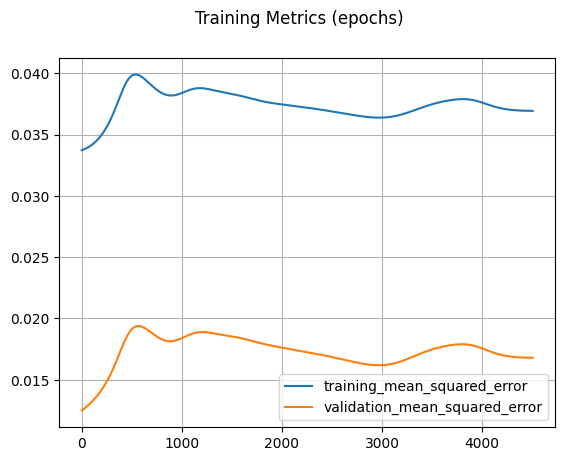

In [18]:
if len(metrics) > 1:
    fig, ax = plt.subplots(1, len(metrics), figsize=(10, 5))
    plt.suptitle('Training Metrics (epochs)')
    for i in range(len(metrics)):
        multy_plot([stats['training_' + metrics[i].__name__], stats['validation_' + metrics[i].__name__]], 
                ['training_' + metrics[i].__name__, 'validation_' + metrics[i].__name__],
                ax=ax[i])
else:
    plt.suptitle('Training Metrics (epochs)')
    multy_plot([stats['training_' + metrics[0].__name__], stats['validation_' + metrics[0].__name__]], 
                ['training_' + metrics[0].__name__, 'validation_' + metrics[0].__name__])

In [19]:

'''plt.suptitle('Training Metrics (epochs)')
for i in range(len(metrics)):
    multy_plot([stats_0['training_' + metrics[i].__name__], stats_0['validation_' + metrics[i].__name__]] + 
               [stats_1['training_' + metrics[i].__name__], stats_1['validation_' + metrics[i].__name__]] +
               [stats_2['training_' + metrics[i].__name__], stats_2['validation_' + metrics[i].__name__]] +
               [stats_3['training_' + metrics[i].__name__], stats_3['validation_' + metrics[i].__name__]],
            ['tr_0.0', 'val_0.0', 'tr_0.25', 'val_0.25', 'tr_0.5', 'val_0.5', 'tr_0.75', 'val_0.75', 'tr_0.95', 'val_0.95',], 
            title='Training Metrics (epochs)')'''

"plt.suptitle('Training Metrics (epochs)')\nfor i in range(len(metrics)):\n    multy_plot([stats_0['training_' + metrics[i].__name__], stats_0['validation_' + metrics[i].__name__]] + \n               [stats_1['training_' + metrics[i].__name__], stats_1['validation_' + metrics[i].__name__]] +\n               [stats_2['training_' + metrics[i].__name__], stats_2['validation_' + metrics[i].__name__]] +\n               [stats_3['training_' + metrics[i].__name__], stats_3['validation_' + metrics[i].__name__]],\n            ['tr_0.0', 'val_0.0', 'tr_0.25', 'val_0.25', 'tr_0.5', 'val_0.5', 'tr_0.75', 'val_0.75', 'tr_0.95', 'val_0.95',], \n            title='Training Metrics (epochs)')"

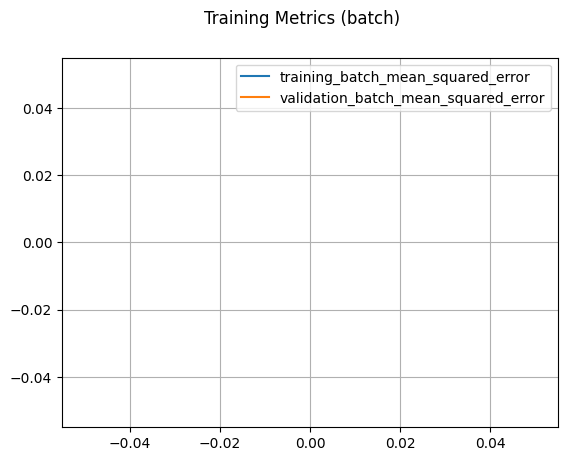

In [20]:
if len(metrics) > 1:
    fig, ax = plt.subplots(1, len(metrics), figsize=(10, 5))
    plt.suptitle('Learning Curve (batch)')
    for i in range(len(metrics)):
        multy_plot([stats['training_batch_' + metrics[i].__name__], stats['validation_batch_' + metrics[i].__name__]], 
                ['training_batch_' + metrics[i].__name__, 'validation_batch_' + metrics[i].__name__],
                ax=ax[i])
    plt.show()
else:
    plt.suptitle('Training Metrics (batch)')
    multy_plot([stats['training_batch_' + metrics[0].__name__], stats['validation_batch_' + metrics[0].__name__]], 
                ['training_batch_' + metrics[0].__name__, 'validation_batch_' + metrics[0].__name__])

In [21]:
'''plt.suptitle('Training Metrics (epochs)')
for i in range(len(metrics)):
    multy_plot([stats_0['training_batch_' + metrics[i].__name__], stats_0['validation_batch_' + metrics[i].__name__]] + 
               [stats_1['training_batch_' + metrics[i].__name__], stats_1['validation_batch_' + metrics[i].__name__]] +
               [stats_2['training_batch_' + metrics[i].__name__], stats_2['validation_batch_' + metrics[i].__name__]] +
               [stats_3['training_batch_' + metrics[i].__name__], stats_3['validation_batch_' + metrics[i].__name__]] + 
               [stats_4['training_batch_' + metrics[i].__name__], stats_4['validation_batch_' + metrics[i].__name__]],
            ['tr_0.0', 'val_0.0', 'tr_0.25', 'val_0.25', 'tr_0.5', 'val_0.5', 'tr_0.75', 'val_0.75', 'tr_0.95', 'val_0.95',], 
            title='Training Metrics (epochs)')'''

"plt.suptitle('Training Metrics (epochs)')\nfor i in range(len(metrics)):\n    multy_plot([stats_0['training_batch_' + metrics[i].__name__], stats_0['validation_batch_' + metrics[i].__name__]] + \n               [stats_1['training_batch_' + metrics[i].__name__], stats_1['validation_batch_' + metrics[i].__name__]] +\n               [stats_2['training_batch_' + metrics[i].__name__], stats_2['validation_batch_' + metrics[i].__name__]] +\n               [stats_3['training_batch_' + metrics[i].__name__], stats_3['validation_batch_' + metrics[i].__name__]] + \n               [stats_4['training_batch_' + metrics[i].__name__], stats_4['validation_batch_' + metrics[i].__name__]],\n            ['tr_0.0', 'val_0.0', 'tr_0.25', 'val_0.25', 'tr_0.5', 'val_0.5', 'tr_0.75', 'val_0.75', 'tr_0.95', 'val_0.95',], \n            title='Training Metrics (epochs)')"

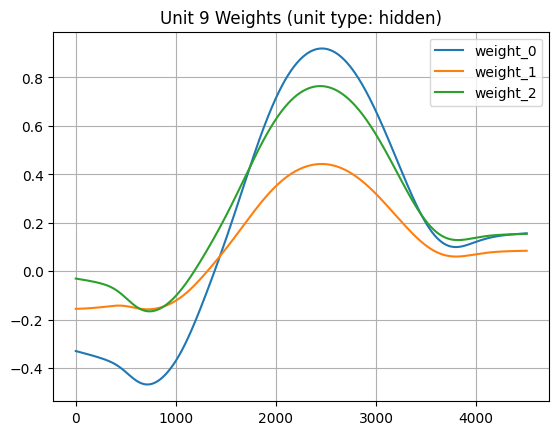

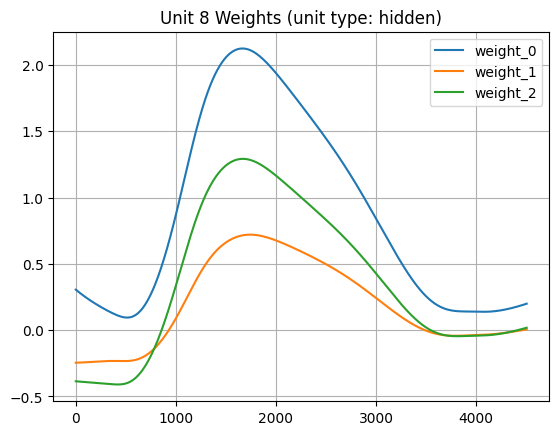

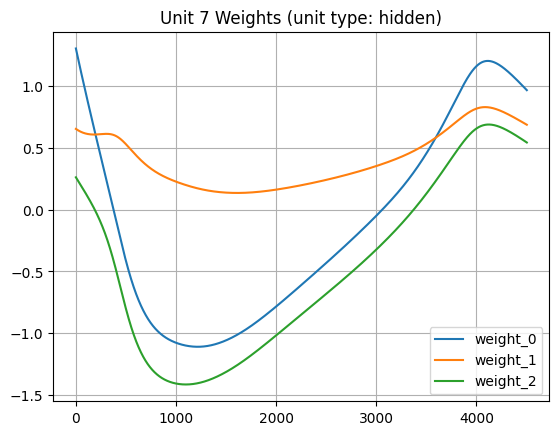

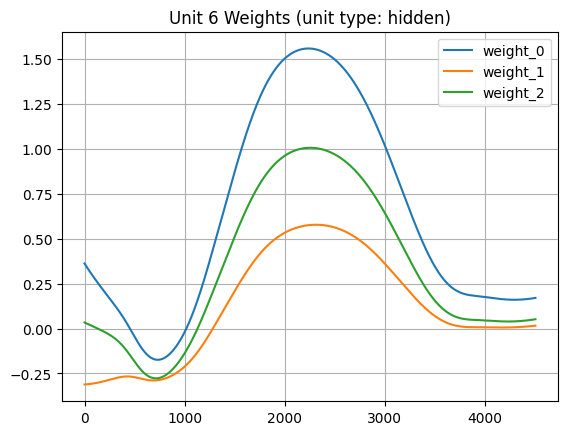

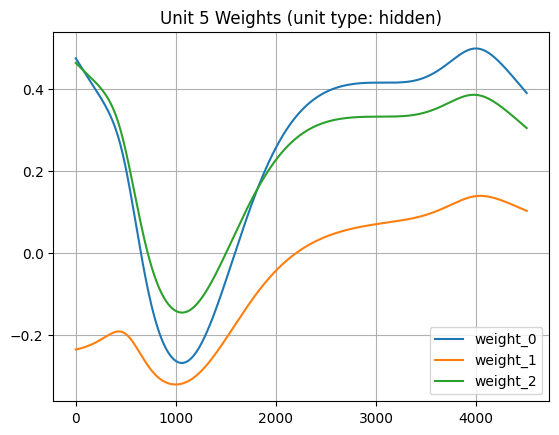

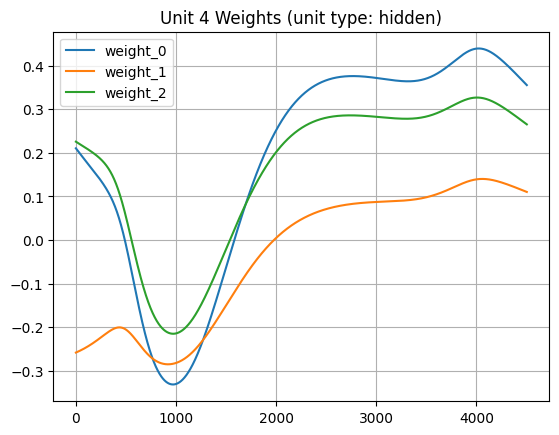

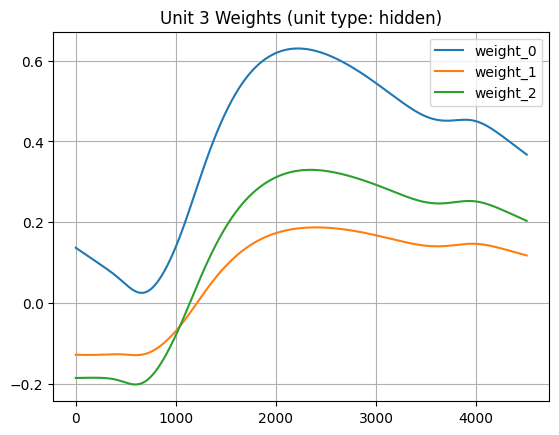

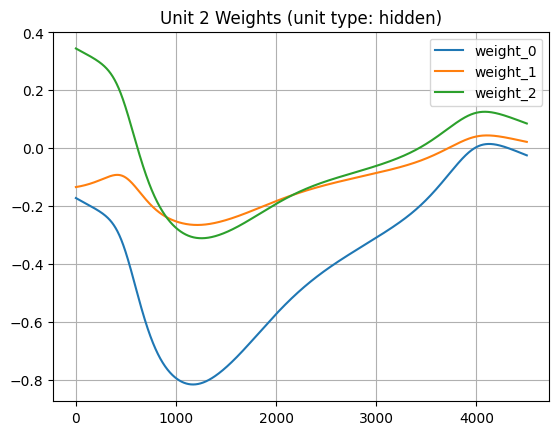

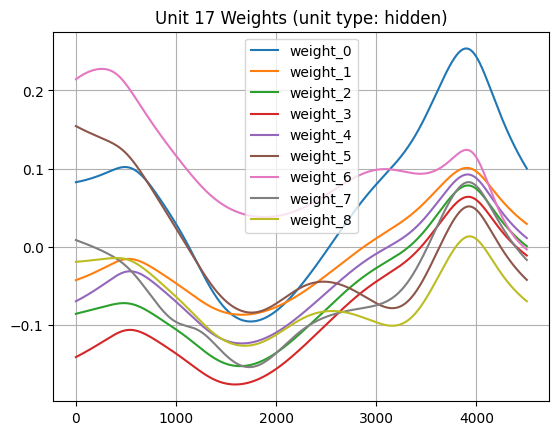

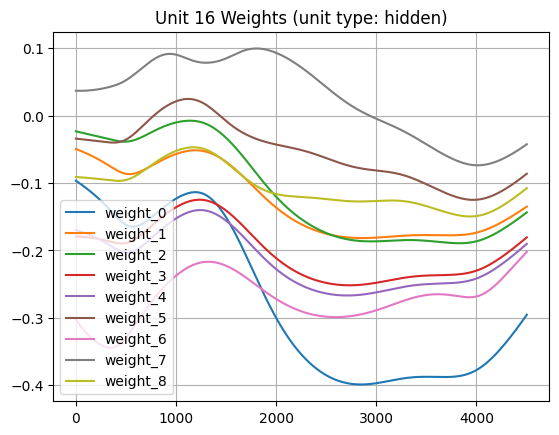

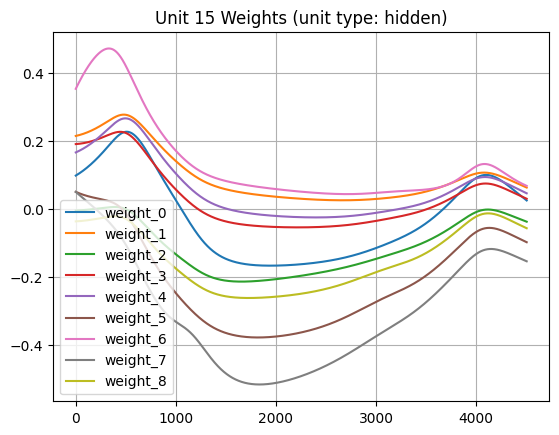

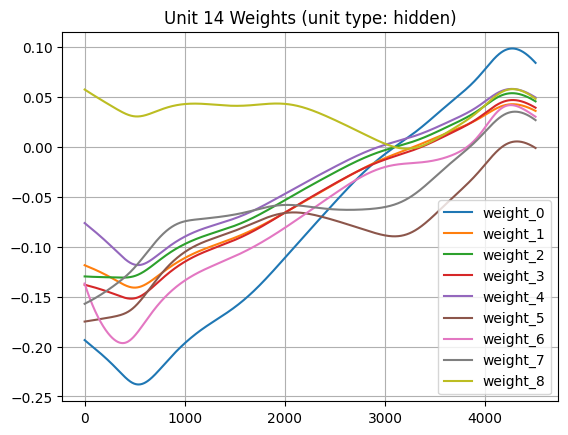

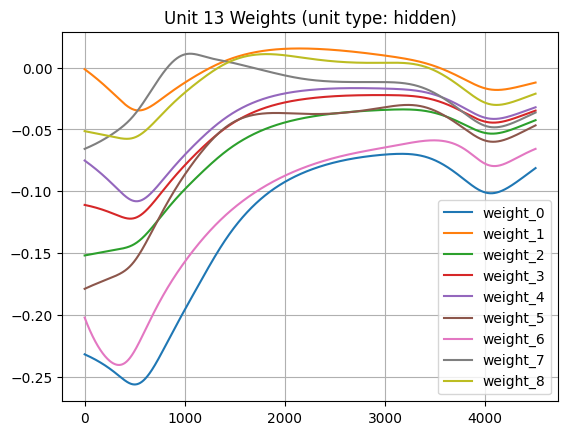

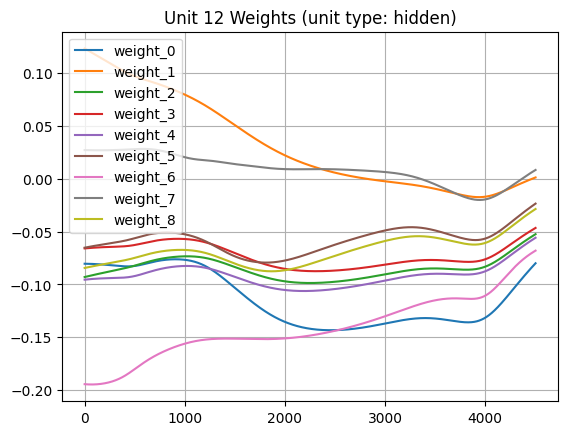

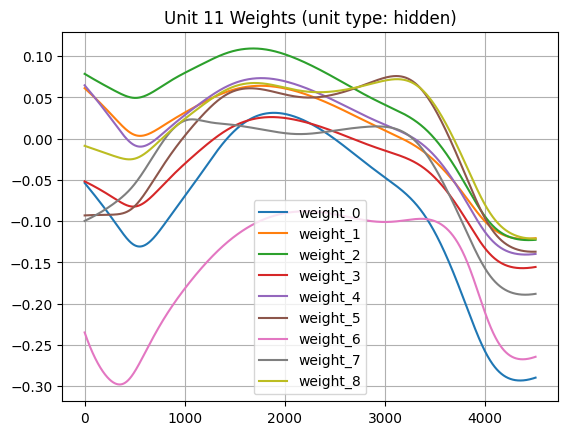

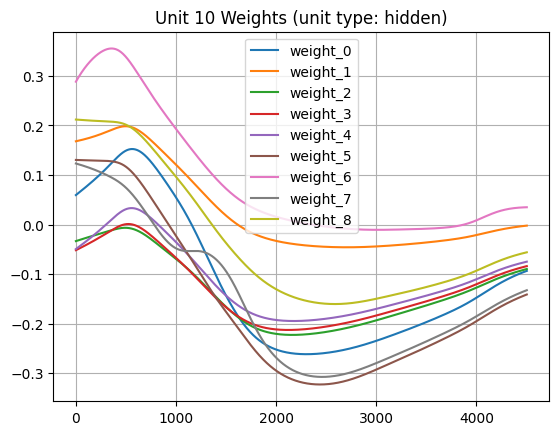

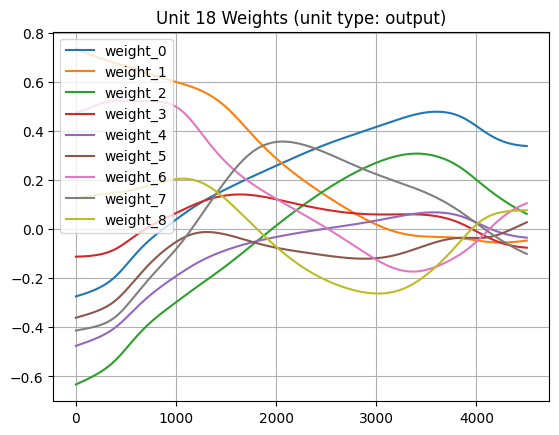

In [22]:
for unit_index in stats['units_weights'].keys():
    vals = np.array(stats['units_weights'][unit_index]).T
    multy_plot(vals, 
               ['weight_' + str(i) for i in range(len(vals))], 
               'Unit ' + str(unit_index) + ' Weights (unit type: ' + NN.neurons[unit_index].type + ')')

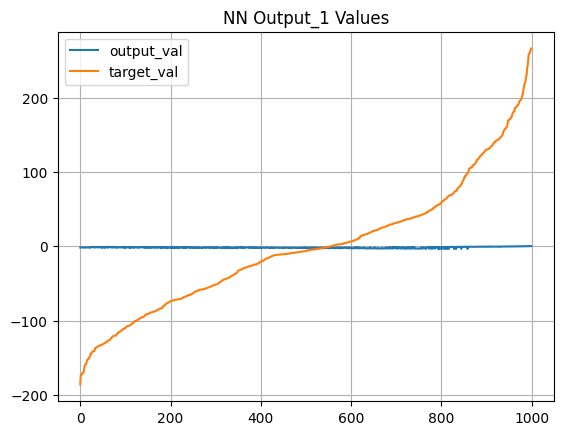

In [23]:
for i in range(TR_OUTPUT):
    sorted_order = training_set[:, TR_INPUT + i].argsort()
    multy_plot([tr_predictions[sorted_order][:,i] , training_set[sorted_order][:,TR_INPUT + i]], 
                ['output_val', 'target_val'], 
                'NN Output_' + str(i + 1) +  ' Values')

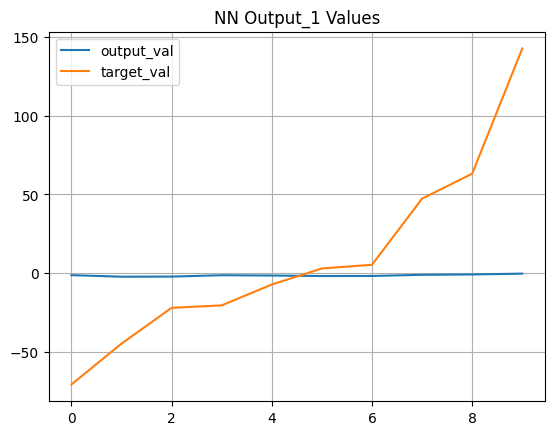

In [24]:
for i in range(TR_OUTPUT):
    sorted_order = validation_set[:, TR_INPUT + i].argsort()
    multy_plot([val_predictions[sorted_order][:,i] , validation_set[sorted_order][:,TR_INPUT + i]], 
                ['output_val', 'target_val'], 
                'NN Output_' + str(i + 1) +  ' Values')

Tot points: 1000


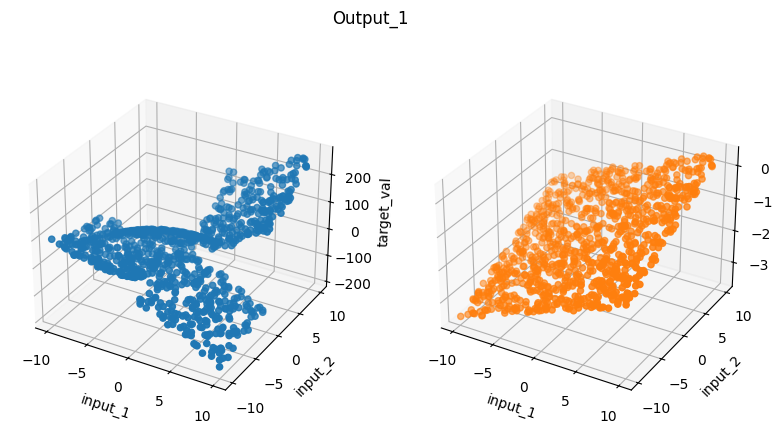

In [25]:
multy_plot_3d([training_set[:,0], training_set[:,0]], 
              [training_set[:,1], training_set[:,1]],
              [training_set[:,TR_INPUT], tr_predictions[:,0]],
              [['input_1', 'input_2', 'target_val'], ['input_1', 'input_2', 'output_val']],
              'Output_1');

In [26]:
interactive_3d_plot(tr_df_normalized, 'input_1', 'input_2', 'prediction_1', 'prediction_1_err')

Tot points: 1000


In [27]:
interactive_3d_plot(tr_df_normalized, 'input_1', 'input_2', 'output_1', 'prediction_1_err')

Tot points: 1000
